# OCR Data audit

We received 4000 Standard bank statements. The idea is to see if we can use this for NTHP. This notebook explores the data quality.

Read the report: https://docs.google.com/document/d/1KWdUMi4WNXbGhY3tmowE6_9HZk-_BOUSFNPd_NEWVjY/edit#

In [18]:
from os import listdir
import xmltodict
import pandas
from StringIO import StringIO
%matplotlib inline
from tqdm import tqdm
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from praelexis_file_system_provider.data_access_layer import AzureBlobStorageDataAccessLayer
import keyring
import PyPDF2
import Levenshtein

### Read the data

It is important that we do not have local copies of the data. Most of the XML files follow a very specific format.

In [19]:
blob_dal = AzureBlobStorageDataAccessLayer('devcapitecdata', 'Gt5z0EAAAm5ZETk//WBnRiQUZ9FDB/BmLmbx5ZPRtDwh6vxTDAB/XzLlM+m/epfnDYcZ8JDfMEGg1p9tBW0iFQ==', 'bank-statements', home_directory='drop/Documentum_line_files')

blob_dal.connect()
files = blob_dal.list(path='CI')


In [20]:
dfs = []
uuids = []
pages = []
errors = []

for file_object in tqdm(files):
    if file_object.name[-3:] == 'xml':
        stream = StringIO()
        blob_dal.get(file_object.directory + file_object.name, stream)
        doc = xmltodict.parse(stream.read())
        try:
            df = pandas.DataFrame(doc['statement']['lineitems']['lineitem'])
            #print df.columns
            if (df.columns == [u'balance', u'deposits', u'description', u'fee', u'payments',u'postdate']).sum() != 6:
                #print "Here"
                raise Exception
            df.loc[:,'file_name'] = file_object.name[:36]
            dfs.append(df)
        except Exception:
            errors.append(doc)
    
    if file_object.name[-3:] == 'pdf':   
        stream = StringIO()
        blob_dal.get(file_object.directory + file_object.name, stream)
        fileReader = PyPDF2.PdfFileReader(stream)
        pages.append(fileReader.numPages)
        uuids.append(file_object.name[:36])

100%|██████████| 8000/8000 [06:02<00:00, 35.13it/s]


In [21]:
print len(dfs)
#print dfs
data_df = pandas.concat(dfs)

3980


In [22]:
print 'Errors:   ', len(errors)
print 'Successes:', len(dfs)

Errors:    20
Successes: 3980


In [23]:
pages_df = pandas.DataFrame({'pages': pages, 'file_name': uuids})
pages_df.head()

,file_name,pages
0,0002a61d-054f-48af-a1da-e67f654cd074,6
1,0012b000-fa76-454f-b4fe-f516b9254cab,2
2,002604d9-ab4b-4aee-9ab0-44b335dccf90,8
3,00341605-e27b-4d9c-9021-530413a47a7e,12
4,003a5996-0f12-42f2-989c-22f0f49d84bd,7


In [24]:
# errors[1]

### Parse

It takes a while to download the data, so let's make a copy. That way we can always run from this point with "raw" data.

In [25]:
lines_df = data_df.copy()

lines_df = lines_df.reset_index()
lines_df.columns = ['ind'] + list(lines_df.columns[1:])

lines_df.head()

,ind,balance,deposits,description,fee,payments,postdate,file_name
0,0,R 1 023.53,None,St i.t.ent opening balances,None,None,None,0002a61d-054f-48af-a1da-e67f654cd074
1,1,R 1 008.53,None,FEE :90 DAY STATEMENT-AUT0PLUS 09H53 TZ41EEN,None,R-15.00,09-23,0002a61d-054f-48af-a1da-e67f654cd074
2,2,R 508.53,None,AUT08ANK CASH hITHDRAWAL AT 0000A294 2017 -09-...,None,R-500.00,09-26,0002a61d-054f-48af-a1da-e67f654cd074
3,3,a 198 .53,None,CAi :H WITHDRAWAL FEE 134348559,None,R-10.00,09-26,0002a61d-054f-48af-a1da-e67f654cd074
4,4,R 366.53,None,AUT0BANK CASH hITH0RAWAL AT 00006277 2017 -09-...,None,R-130.00,09-28,0002a61d-054f-48af-a1da-e67f654cd074


In [26]:

def clean_date(date_string):
    try:
        parts = date_string.split('-')     
        return date(2016, int(parts[0]), int(parts[1]))
    except Exception:
        return None

def clean_amount(amount):
    try:
        amount = amount.replace('R', '')
        amount = amount.replace(',', '')
        amount = amount.replace(' ', '')
        
        return float(amount)
    except Exception:
        return None
    
def parse_line(x):
    x.postdate = clean_date(x.postdate)
    x.fee = clean_amount(x.fee)
    x.payments = clean_amount(x.payments)
    x.deposits = clean_amount(x.deposits)
    x.balance = clean_amount(x.balance)        
    return x

lines_df = lines_df.apply(parse_line, axis=1)
lines_df.head()

,ind,balance,deposits,description,fee,payments,postdate,file_name
0,0,1023.53,NaN,St i.t.ent opening balances,NaN,NaN,None,0002a61d-054f-48af-a1da-e67f654cd074
1,1,1008.53,NaN,FEE :90 DAY STATEMENT-AUT0PLUS 09H53 TZ41EEN,NaN,-15.0,2016-09-23,0002a61d-054f-48af-a1da-e67f654cd074
2,2,508.53,NaN,AUT08ANK CASH hITHDRAWAL AT 0000A294 2017 -09-...,NaN,-500.0,2016-09-26,0002a61d-054f-48af-a1da-e67f654cd074
3,3,NaN,NaN,CAi :H WITHDRAWAL FEE 134348559,NaN,-10.0,2016-09-26,0002a61d-054f-48af-a1da-e67f654cd074
4,4,366.53,NaN,AUT0BANK CASH hITH0RAWAL AT 00006277 2017 -09-...,NaN,-130.0,2016-09-28,0002a61d-054f-48af-a1da-e67f654cd074


In [27]:
print 'Completeness'
print 'Post date:                        ', lines_df[lines_df.postdate.notnull()].shape[0] / float(lines_df.shape[0])
print 'Post date (without first lines):  ', lines_df[lines_df.postdate.notnull()].shape[0] / float(lines_df.shape[0] - len(lines_df['file_name'].unique()))
print 'Description:                      ', lines_df[lines_df.description.notnull()].shape[0] / float(lines_df.shape[0])
print 'Amount cols:                      ', lines_df[lines_df.fee.notnull() | lines_df.payments.notnull() | lines_df.deposits.notnull()].shape[0] / float(lines_df.shape[0])
print 'Amount cols(without first lines): ', lines_df[lines_df.fee.notnull() | lines_df.payments.notnull() | lines_df.deposits.notnull()].shape[0] / float(lines_df.shape[0] - len(lines_df['file_name'].unique()))
print 'Balance:                          ', lines_df[lines_df.balance.notnull()].shape[0] / float(lines_df.shape[0])

Completeness
Post date:                         0.594373976256
Post date (without first lines):   0.605240909049
Description:                       0.932215167883
Amount cols:                       0.715558202813
Amount cols(without first lines):  0.728640745472
Balance:                           0.88483978828


### Row counts

Stetements with 20 lines: 0.360392058306


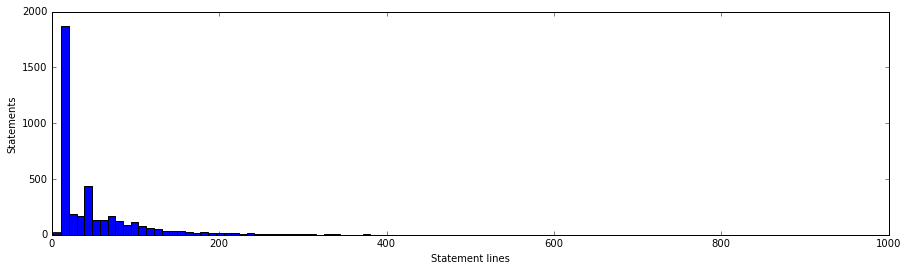

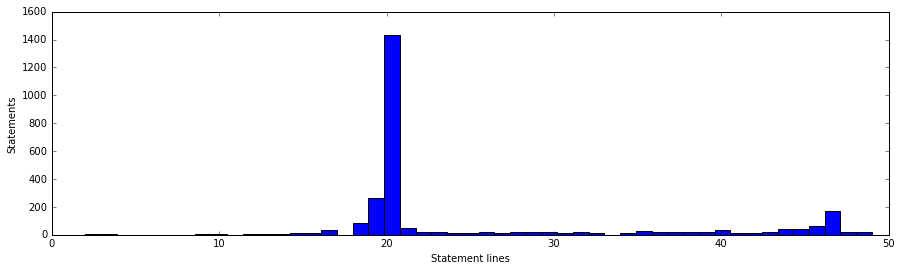

In [28]:
row_counts = lines_df[['file_name', 'ind']].groupby('file_name').count().reset_index()
ax = row_counts.plot.hist(bins=100, figsize=(15,4), legend=False)
ax.set_xlabel('Statement lines')
ax.set_ylabel('Statements')
ax = row_counts[row_counts.ind < 50].plot.hist(bins=50, figsize=(15,4), legend=False)
ax.set_xlabel('Statement lines')
ax.set_ylabel('Statements')
print 'Stetements with 20 lines:', row_counts[row_counts.ind == 20].shape[0] / float(row_counts.shape[0])

Statements with 20 or fewer lines and 2 or more pages: 0.461383647799
Statements with 20 or fewer lines and 3 or more pages: 0.402264150943


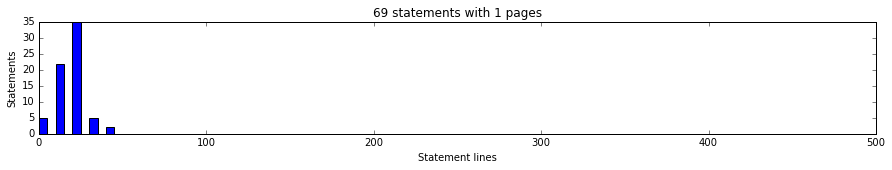

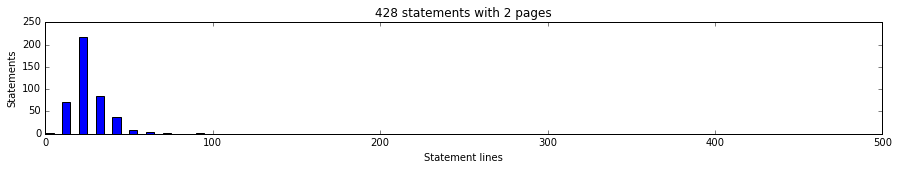

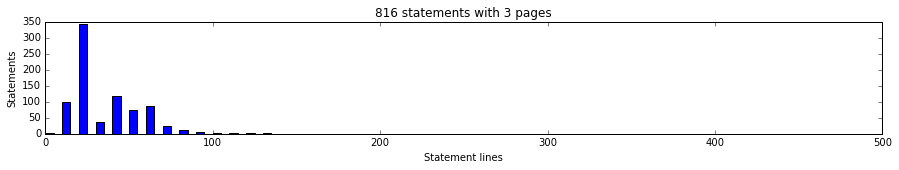

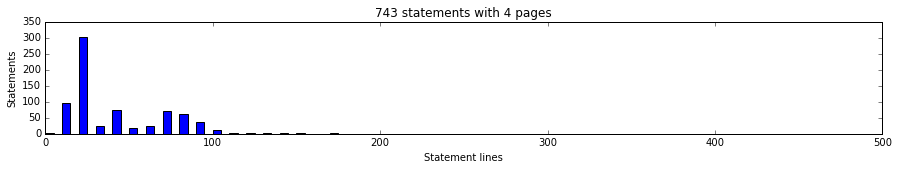

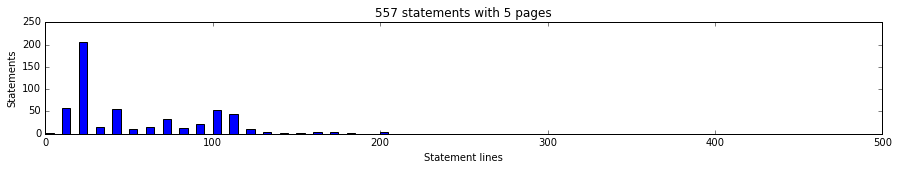

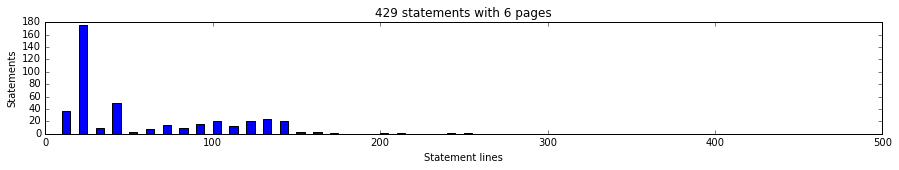

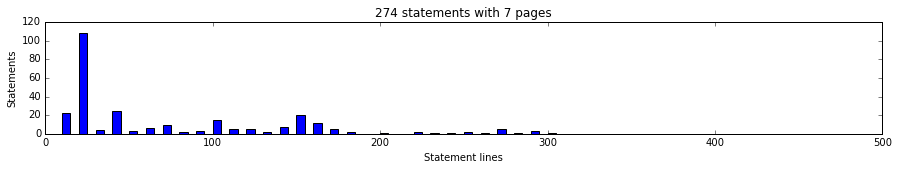

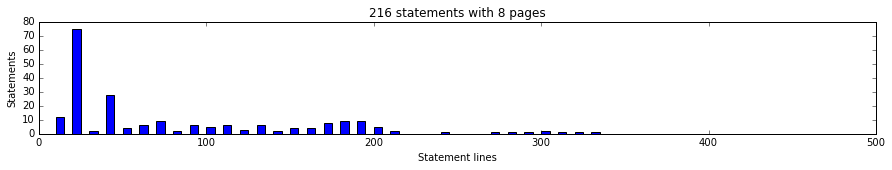

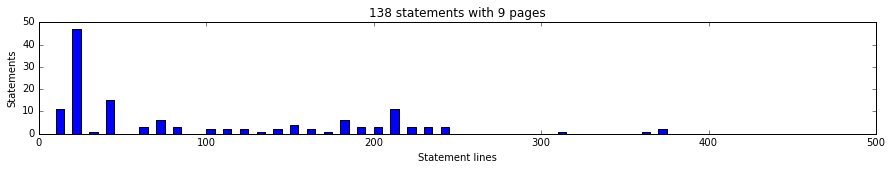

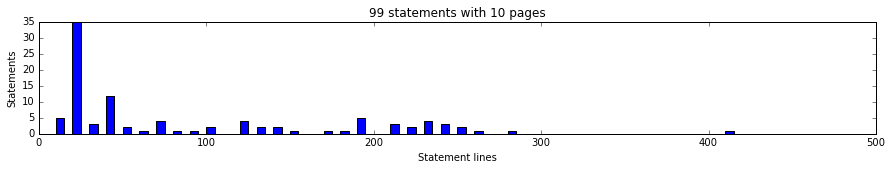

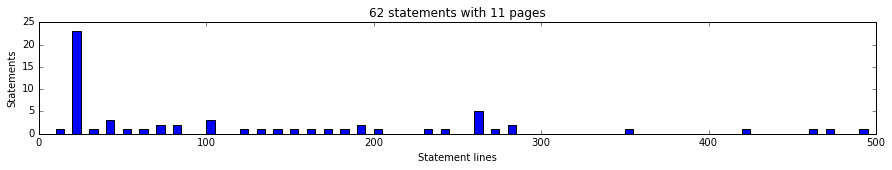

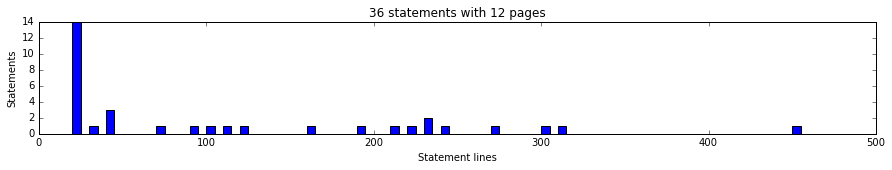

In [29]:
rows_and_pages = row_counts.merge(pages_df, on='file_name')

for i in range(12):
    df_temp = rows_and_pages[rows_and_pages.pages == (i+1)]
    a_heights, a_bins = np.histogram(df_temp['ind'], bins=50, range=[0,500])
    fig, ax= plt.subplots(figsize=(15,2))
    ax.bar(a_bins[:-1], a_heights, width=5)
    ax.set_xlim([0,500])
    ax.set_xlabel('Statement lines')
    ax.set_ylabel('Statements')
    ax.set_title('{} statements with {} pages'.format(df_temp.shape[0], i+1))

print 'Statements with 20 or fewer lines and 2 or more pages:', rows_and_pages[(rows_and_pages.ind <= 20) & (rows_and_pages.pages > 1)].shape[0]/float(rows_and_pages.shape[0])
print 'Statements with 20 or fewer lines and 3 or more pages:', rows_and_pages[(rows_and_pages.ind <= 20) & (rows_and_pages.pages > 2)].shape[0]/float(rows_and_pages.shape[0])

### Date ranges

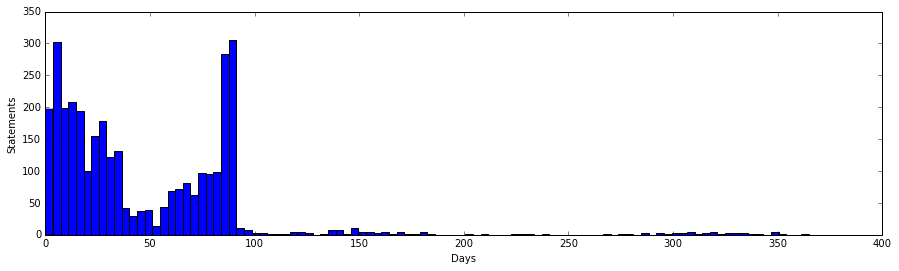

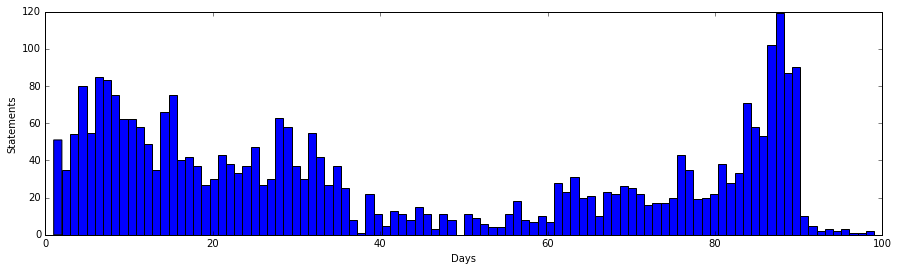

In [30]:
ranges_df = lines_df[['file_name', 'postdate']].dropna(axis=0,how='any').groupby('file_name').agg({'postdate': ['first', 'last']}).reset_index()

def get_number_of_days(x):
    start = x.postdate.values[0] 
    end = x.postdate.values[1]
    # If the end data is before the start date, the start date should probably be in the previous year.
    if (end - start).days < 0:
        start = start.replace(year=2015)
    return (end - start).days
    
    
ranges_df.loc[:, 'days'] = ranges_df.apply(get_number_of_days,axis=1)
ax = ranges_df[['file_name', 'days']].plot.hist(bins=100, figsize=(15,4), legend=False)
ax.set_xlabel('Days')
ax.set_ylabel('Statements')
ax = ranges_df[(ranges_df.days > 0) & (ranges_df.days < 100)][['file_name', 'days']].plot.hist(bins=100, figsize=(15,4), legend=False)
ax.set_xlabel('Days')
_ = ax.set_ylabel('Statements')

### Descriptions

This is done on the assuption that the first line of a statement is 'Statement opening balances'.

In [31]:
def get_distance(x):
    try:
        description = ''.join(e for e in x.description if ord(e) < 128)
        distance = Levenshtein.distance(str(description), 'Statement opening balances')
        if distance > 100:
            return 100
        return distance
        
    except Exception as e:
        pass
        print e
    return None

first_descriptions = lines_df.groupby('file_name').agg({'description': 'first'}).reset_index()
first_descriptions.loc[:, 'distance'] = first_descriptions[first_descriptions.description.notnull()].apply(get_distance, axis=1)

Match exactly: 0.394571500377
1 edit       : 0.133199296306
2 edits      : 0.11610957527
3 edits      : 0.0263885398341
4 edits      : 0.0138225684845
5 edits      : 0.0105554159337
6 edits      : 0.00351847197788
7 edits      : 0.00251319426992
8 edits      : 0.00678562452878
40 edits      : 0.00351847197788
(0,)


Series([], Name: description, dtype: object)

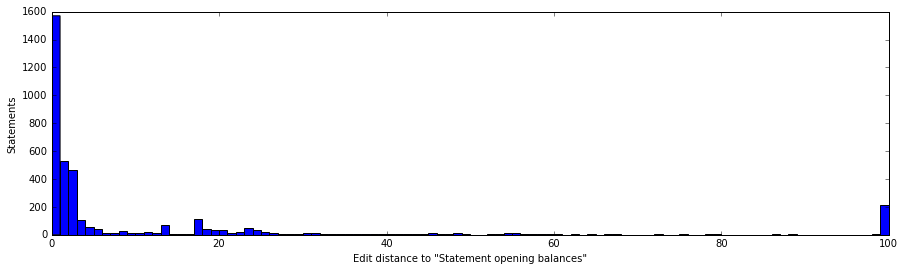

In [32]:
ax = first_descriptions[first_descriptions.distance >= 0][['distance']].plot.hist(bins=100, figsize=(15,4), legend=False)
ax.set_xlabel('Edit distance to "Statement opening balances"')
ax.set_ylabel('Statements')

print 'Match exactly:', first_descriptions[first_descriptions.distance == 0][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '1 edit       :', first_descriptions[first_descriptions.distance == 1][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '2 edits      :', first_descriptions[first_descriptions.distance == 2][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '3 edits      :', first_descriptions[first_descriptions.distance == 3][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '4 edits      :', first_descriptions[first_descriptions.distance == 4][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '5 edits      :', first_descriptions[first_descriptions.distance == 5][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '6 edits      :', first_descriptions[first_descriptions.distance == 6][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '7 edits      :', first_descriptions[first_descriptions.distance == 7][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '8 edits      :', first_descriptions[first_descriptions.distance == 8][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])
print '40 edits      :', first_descriptions[first_descriptions.distance == 10][['distance']].shape[0] / float(first_descriptions[['distance']].shape[0])


window = first_descriptions[(first_descriptions.distance >= 50) & (first_descriptions.distance < 51)]['description']
print window.shape
window.head(20)

### Balance accuracy

We assume the balance should be the previous balance with the transaction amount added.

In [33]:
results = []
ids = []
total = 0

for statement_name in tqdm(lines_df['file_name'].unique()):
    statement_df = lines_df[lines_df.file_name == statement_name]
    
    statement_result = 0
    
    
    for i in range(1,statement_df.shape[0]):
        line = statement_df.iloc[i].to_dict()
        previous_line = statement_df.iloc[i-1].to_dict()
        #print line
        result = 0
        
        if not math.isnan(line['fee']):
            if previous_line['balance'] + line['fee'] == line['balance']:
                result = 1
            
        if not math.isnan(line['payments']):
            if previous_line['balance'] + line['payments'] == line['balance']:
                result = 1

        if not math.isnan(line['deposits']):
            if previous_line['balance'] + line['deposits'] == line['balance']:
                result = 1
            
        if math.isnan(line['fee']) + math.isnan(line['payments']) + math.isnan(line['deposits']) != 2:
            result = 0
        
        statement_result += result
        total += result
    
    results.append(statement_result/float(statement_df.shape[0]))
    ids.append(statement_name)
        
balance_df = pandas.DataFrame({'file_name': ids, 'balance_accuracy':results})    
print 'Total balance accuracy', total / float(lines_df.shape[0] - len(lines_df['file_name'].unique()))

100%|██████████| 3979/3979 [01:52<00:00, 35.27it/s]

Total balance accuracy 0.328919194611


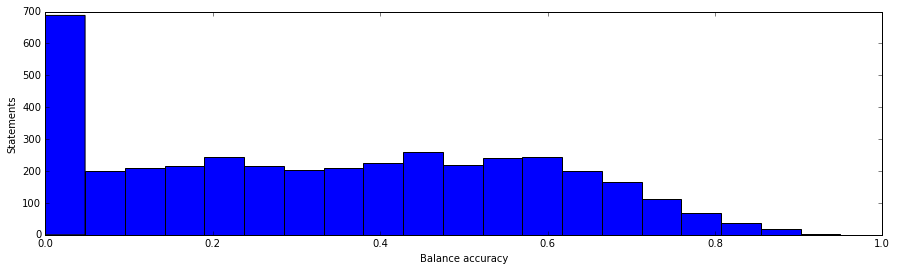

In [34]:
ax = balance_df.plot.hist(bins=20, figsize=(15,4), legend=False)
ax.set_xlabel('Balance accuracy')
ax.set_ylabel('Statements')